In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import erfc
from scipy.signal import find_peaks

In [ ]:
import sipm.sipm as sipm
import sipm.dataset as ds

In [ ]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
# path1 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:prepurification/"
path1 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-06/2022-10-06_volt:65_pos:top_light:scint_cond:postpurification_split_20/"
path1 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-09-23/20220923_64V_laser_3718thres/"

# path2 = "/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-10-07/2022-10-07_volt_70_pos_top_light_scint_0/"

In [ ]:
data1 = ds.Dataset(path1, pol=-1, channels=[0,1,2,3], samples=2048)
data1.ch[0].read_data(header=False)
# data1.ch[0].bandpass_filter(10,5e6,1)
data1.ch[0].baseline_subtraction()

In [ ]:
def func3(x,base,V0,mu,sigma,tau,tau2):
    return base + V0/2.0 * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma)) * ( np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) + np.exp(0.5 * (sigma/tau2)**2 - (x-mu)/tau2))

In [ ]:
def gauss(x,mu=0,sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

time = data1.ch[0].time
desire_x = np.linspace(-len(time)//2,len(time)//2,len(time))
desire_y = gauss(desire_x, mu=0, sigma=.1)
resp_x = np.linspace(-10,10000,len(time))
resp_y = func3(resp_x, 0, 1, 0, 1.83, 40.0, 500.0)

resp_f = np.fft.fft(resp_y)
desire_f = np.fft.fft(desire_y)
filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

integ1 = []
integ2 = []
integ3 = []
amp = []

for i in range(len(data1.ch[0].traces)):
# for i in range(1000,1010):
    deconv = np.convolve(data1.ch[0].traces[i],filter_y,'same')
    scaling = 20000
    deconv *= scaling
    pp,pdict = find_peaks(deconv, prominence=0.1, height=0.1, width=3)
    
    integ1.append(np.sum(data1.ch[0].traces[i][800:1800]))
    # print([ppos for ppos in pp])
    if len(pp)>0:
        integ2.append(np.sum(deconv[pp[0]-10:pp[0]+10]))
    else:
        integ2.append(0)
    integ3.append(np.sum(deconv[pp[:1]]))
    amp.append(np.max(data1.ch[0].traces[i]))
    
    if i>1100 and i<1120:
        plt.figure()
        plt.scatter(time[pp], deconv[pp], color='k', s=5, zorder=10)
        # plt.plot(time, data1.ch[0].traces[i],label='Response', color=colors[0])
        plt.plot(time, deconv,label='Deconvolved', lw=1, alpha=1, color=colors[1])
        # plt.ylim(-1,5)
        plt.show()

    if i > 1120:
        break

150
300
250
500
1024
2048
1024
2048


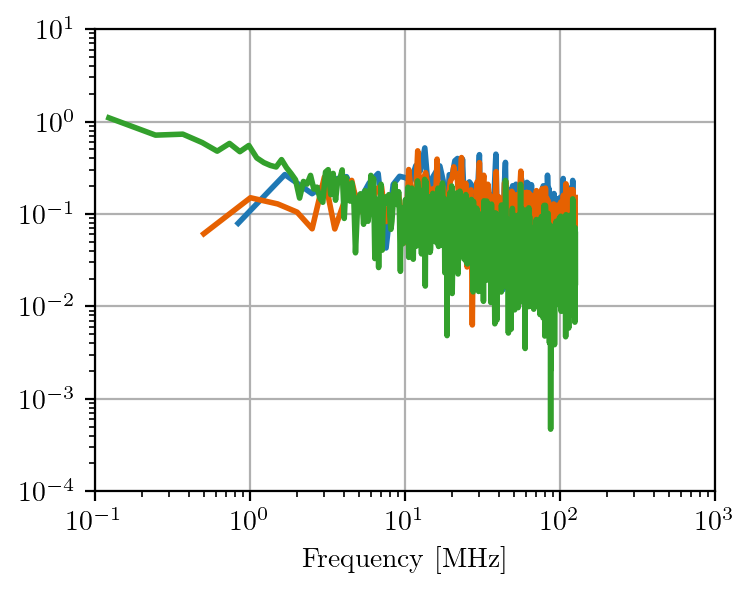

In [42]:
from scipy.fft import fft, fftfreq

# Number of sample points
N = 500
# sample spacing
ffts = [] 
fftsx = [] 
for N in [300,500,2048]:
    T = 1.0 / 250000000.0
    x = np.linspace(0.0, N*T, N, endpoint=False)
    y = data1.ch[0].traces[1000][:N]
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    xf = xf/1e6

    fftsx.append(xf)
    ffts.append(yf)

    print(len(xf))
    print(len(yf))
    

    # plt.figure()
    # plt.plot(time, data1.ch[0].traces[1000])
    # plt.show()

print(len(xf))
print(len(yf))
plt.figure()
for i,N in enumerate([300,500,2048]):
    # plt.loglog(xf[1:N//2], 2.0/N * np.abs(yf[1:N//2]), '-b')
    plt.loglog(fftsx[i][1:N//2], 2.0/N * np.abs(ffts[i][1:N//2]))
plt.xlabel('Frequency [MHz]')
plt.grid()
plt.show()

In [ ]:
integ1 = np.array(integ1)
integ2 = np.array(integ2)
integ3 = np.array(integ3)
amp = np.array(amp)

In [ ]:
plt.figure()
plt.scatter(amp, integ3, marker='o', s=.001)
plt.xlim(1e0,1e2)
plt.ylim(1e-1,2e0)
plt.xscale('log')
plt.yscale('log')
plt.show() 

In [ ]:
plt.figure()
# plt.hist(integ1/70.0, bins=np.arange(0,200,.1), histtype='step', label='Integral Original')
plt.hist(integ2*2.44, bins=np.arange(0,100,.1), histtype='step', label='Integral Deconvolved')
# plt.hist(integ3*31, bins=np.arange(0,100,.1), histtype='step', label='Sum Deconvolved')
plt.hist(amp, bins=np.arange(0,100,.1), histtype='step', label='Amplitude', lw=1)
plt.yscale('log')
plt.legend(loc='upper right')
plt.show()

In [ ]:
plt.figure()
plt.plot(resp_x, resp_y/np.max(resp_y),label='Response')
plt.plot(desire_x, desire_y/np.max(desire_y),label='Desired', lw=1)
plt.legend(loc='upper right')
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Normalized Amplitude')
plt.show()

In [ ]:
plt.figure()
# plt.plot(resp_x, resp_y/np.max(resp_y),label='Response')
# plt.plot(desire_x, desire_y/np.max(desire_y),label='Desired', lw=1)
plt.plot(desire_x, filter_y,label='Template', lw=1)
plt.legend(loc='upper right')
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Normalized Amplitude')
plt.show()

In [ ]:
plt.figure()
plt.plot(data1.ch[0].time, data1.ch[0].traces[4])
plt.show() 

In [ ]:
data1 = ds.Dataset(path1, pol=-1, channels=[0,1,2,3], samples=3000)
data1.ch[0].read_data()
data2 = ds.Dataset(path2, pol=-1, channels=[0,1,2,3], samples=3000)
data2.ch[0].read_data()

In [ ]:
trigger = int(0.4 * len(data1.ch[0].time))-80
plt.figure()
for i in range(10):
    trace1 = data1.ch[0].traces[i] - np.mean(data1.ch[0].traces[i][:200])
    trace2 = data2.ch[0].traces[i] - np.mean(data2.ch[0].traces[i][:200])
    plt.plot(data1.ch[0].time, trace1, color='k', alpha=0.3)
    plt.plot(data1.ch[0].time, trace2, color='r', alpha=0.3)

plt.vlines(x=data1.ch[0].time[trigger], ymin=-250, ymax=50, linestyles='--', color='k', lw=1)
plt.vlines(x=data1.ch[0].time[trigger+1000], ymin=-250, ymax=50, linestyles='--', color='k', lw=1)
plt.show()

In [ ]:
integral1 = []
integral2 = []

for i in range(9900):
    trace1 = data1.ch[0].traces[i] - np.mean(data1.ch[0].traces[i][:200])
    trace2 = data2.ch[0].traces[i] - np.mean(data2.ch[0].traces[i][:200])
    integral1.append(-1*np.sum(trace1[trigger:trigger+1000]))
    integral2.append(-1*np.sum(trace2[trigger:trigger+1000]))

plt.figure()
plt.plot(data1.ch[0].timestamp[:9900], integral1, color='k')
plt.plot(data2.ch[0].timestamp[:9900], integral2, color='r')
# plt.xscale('log')
# plt.yscale('log')
# plt.ylim(1e-1,1e7)
plt.show()

In [ ]:
plt.figure()
plt.hist(integral1, bins=np.arange(0,200000,400), histtype='step', label='pre')
plt.hist(integral2, bins=np.arange(0,200000,400), histtype='step', label='post')
plt.ylim(1e-1,1e3)
# plt.xscale('log')
plt.xlim(0.1,1e5)
plt.yscale('log')
plt.xlabel('Integral')
plt.ylabel('Counts/bin')
plt.legend(loc='upper right')
plt.show()

In [ ]:
data.ch[0].read_data()

In [ ]:
for volt in voltages[-1:]:
    data = ds.Dataset(path.format(volt), pol=-1, channels=channels)
    print(data.ch[0].file)
    for i in channels:
        print("Analyzing channel {}".format(i))
        data.ch[i].read_data()
        data.ch[i].bandpass_filter(low=10, high=8e6, order=3)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_max()
        data.ch[i].get_integral()
        data.ch[i].clear()

In [ ]:
# index = 20410
# plt.figure()
# plt.xlim(-1,10)
# plt.plot(data.ch[0].time, data.ch[0].traces[index])
# plt.vlines(x=data.ch[0].time[500], ymin=-2, ymax=8, color='r', lw=1)
# plt.vlines(x=data.ch[0].time[data.ch[0].peak_pos[index]-50], ymin=-2, ymax=8, color='r', lw=1)
# plt.vlines(x=data.ch[0].time[data.ch[0].peak_pos[index]+650], ymin=-2, ymax=8, color='r', lw=1)
# plt.show()
# print(np.sum(data.ch[0].traces[index][data.ch[0].peak_pos[index]-80:data.ch[0].peak_pos[index]+600]))

In [ ]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].peak, bins=np.arange(0,100,0.1), histtype='step')
plt.yscale('log')
plt.show()

In [ ]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].peak_pos, bins=np.arange(0,2048,10), histtype='step')
plt.yscale('log')
plt.show()

In [ ]:
plt.figure()
for i in channels:
    plt.hist(data.ch[i].integral, bins=np.arange(0,10000,10), histtype='step')
plt.yscale('log')
plt.show()